### BABILong: evaluation example

Download BABILong repository.


In [1]:
pip install datasets transformers flash_attention accelerate

In [ ]:
!git clone https://github.com/booydar/babilong source

In [2]:
import torch
import datasets
from transformers import AutoTokenizer, AutoModelForCausalLM

from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from source.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from source.babilong.babilong_utils import compare_answers

Let's check how BABILong data looks like:

In [7]:
# take split with 0k tokens length (no background texts from PG-19), 100 samples per task and per length
# use "RMT-team/babilong-1k" for 1000 samples per task per length
data_0k = datasets.load_dataset("RMT-team/babilong", '0k')
print(data_0k)

DatasetDict({
    qa1: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa2: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa3: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa4: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa5: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa6: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa7: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa8: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa9: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
    })
    qa10: Dataset({
        features: ['question', 'input', 'target'],
        num_rows: 100
  

In [15]:
# the first sample from qa1 with no background texts
for k in data_0k['qa1'][0]:
    print(f"{k}: {data_0k['qa1'][0][k]}")

question: Where is Mary? 
input: John travelled to the hallway. Mary journeyed to the bathroom. Daniel went back to the bathroom. John moved to the bedroom.
target: bathroom


In [14]:
# data split with 1k tokens
data_1k = datasets.load_dataset("RMT-team/babilong", '1k')
# the first sample from qa1 with no background texts
for k in data_1k['qa1'][0]:
    print(f"{k}: {data_1k['qa1'][0][k]}")

question: Where is Mary? 
input: According to the lawyers’ conception, whatever might be the
powers of Parliament when it actually came together, however much the
King might be bound to act by its advice, consent, and authority, the
Parliament itself did nevertheless derive its being from the authority
of the King. Parliament was summoned by the King’s writ. The King
might indeed be bound to issue the writs for its summons; still it was
from the King’s writ that the Parliament actually derived its being
and its powers. By another legal assumption, the force of the King’s
writ was held to last only during the lifetime of the King who issued
it. It followed therefore that Parliament, summoned by the King’s
writ and deriving its authority from the King’s writ, was dissolved
_ipso facto_ by the death of the King who summoned it. Once admit the
assumptions from which this reasoning starts, and the reasoning itself
is perfect. Let us see how
this mass of legal subtlety would have looked in t

Let's prepare sample with prompts, instructions and in-context examples:

In [18]:
from source.babilong.prompts import DEFAULT_TEMPLATE, DEFAULT_PROMPTS, get_formatted_input

task = 'qa1'
# use instruction, in-context examples, and instruction after examples
prompt_cfg = {
    'instruction': DEFAULT_PROMPTS[task]['instruction'],
    'examples': DEFAULT_PROMPTS[task]['examples'],
    'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
    'template': DEFAULT_TEMPLATE,
    }

print(f'default template: {DEFAULT_TEMPLATE}')

default template: {instruction}

{examples}

{post_prompt}

<context>
{context}
</context>

Question: {question}


So, this is how input to the model is formed. You can use other templates or instructions. We provide current configuration as an example.

In [24]:
sample = data_0k[task][0]

print(get_formatted_input(sample['input'], sample['question'],
                    prompt_cfg['examples'], prompt_cfg['instruction'],
                    prompt_cfg['post_prompt'], template=DEFAULT_TEMPLATE))

I will give you context with the facts about positions of different persons hidden in some random text and a question. You need to answer the question based only on the information from the facts. If a person was in different locations, use the latest location to answer the question.

<example>
Charlie went to the hallway. Judith come back to the kitchen. Charlie travelled to balcony. Where is Charlie?
Answer: The most recent location of Charlie is balcony.
</example>

<example>
Alan moved to the garage. Charlie went to the beach. Alan went to the shop. Rouse travelled to balcony. Where is Alan?
Answer: The most recent location of Alan is shop.
</example>

Always return your answer in the following format: The most recent location of ’person’ is ’location’. Do not write anything else after that.

<context>
John travelled to the hallway. Mary journeyed to the bathroom. Daniel went back to the bathroom. John moved to the bedroom.
</context>

Question: Where is Mary?


Let's run Phi3-mini on tasks from BABILong, save prediction, and plot results.

In [3]:
results_folder = './babilong_evals'
model_name = 'microsoft/Phi-3-mini-128k-instruct'
dtype = torch.bfloat16
device = 'cuda:0'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True,
                                             device_map=device, torch_dtype=dtype,)
                                            #  attn_implementation='flash_attention_2') # uncomment to run with flash attention 2
model = model.eval()

In [6]:
# specify tasks and lengths
tasks = ['qa1', 'qa2'] #[,'qa3', 'qa4', 'qa5']
split_names = ['0k', '1k'] #, '2k', '4k', '8k', '16k', '32k']

In [11]:
generate_kwargs = {
      'max_new_tokens': 20,
      'max_length': None,
      'num_beams': 1,
      'do_sample': False,
      'temperature': None,
      'top_p': None,
      'top_k': None,
      'pad_token_id': tokenizer.pad_token_id
  }

if generate_kwargs['pad_token_id'] is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

use_chat_template = True
use_instruction = True
use_examples = True
use_post_prompt = True

In [13]:
for task in tqdm(tasks, desc='tasks'):
        # configure the prompt
        prompt_cfg = {
            'instruction': DEFAULT_PROMPTS[task]['instruction'] if use_instruction else '',
            'examples': DEFAULT_PROMPTS[task]['examples'] if use_examples else '',
            'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'] if use_post_prompt else '',
            'template': DEFAULT_TEMPLATE,
            'chat_template': use_chat_template,
        }
        prompt_name = [f'{k}_yes' if prompt_cfg[k] else f'{k}_no' for k in prompt_cfg if k != 'template']
        prompt_name = '_'.join(prompt_name)

        for split_name in tqdm(split_names, desc='lengths'):
            # load dataset
            data = datasets.load_dataset('RMT-team/babilong', split_name)
            task_data = data[task]

            # Prepare files with predictions, prompt, and generation configurations
            outfile = Path(f'{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.csv')
            outfile.parent.mkdir(parents=True, exist_ok=True)
            cfg_file = f'./{results_folder}/{model_name}/{task}_{split_name}_{prompt_name}.json'
            json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

            df = pd.DataFrame({'target': [], 'output': [], 'question': []})

            for sample in tqdm(task_data, desc=f'task: {task} length: {split_name}'):
                target = sample['target']
                context = sample['input']
                question = sample['question']

                # format input text
                input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                                 prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                                 template=prompt_cfg['template'])

                if use_chat_template:
                    input_text = [{'role': 'user', 'content': input_text}]
                    model_inputs = tokenizer.apply_chat_template(input_text, add_generation_prompt=True,
                                                                 return_tensors='pt').to(model.device)
                    model_inputs = {'input_ids': model_inputs}
                else:
                    model_inputs = tokenizer(input_text, return_tensors='pt',
                                             add_special_tokens=True).to(model.device)

                sample_length = model_inputs['input_ids'].shape[1]
                with torch.no_grad():
                    output = model.generate(**model_inputs, **generate_kwargs)

                output = output[0][sample_length:]
                output = tokenizer.decode(output, skip_special_tokens=True).strip()

                df.loc[len(df)] = [target, output, question]
                # write results to csv file
                df.to_csv(outfile)

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

lengths:   0%|          | 0/2 [00:00<?, ?it/s]

task: qa1 length: 0k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/2 [00:00<?, ?it/s]

task: qa2 length: 0k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa2 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

## Compute metrics and plot results

In [16]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import os

import pandas as pd
import numpy as np

from source.babilong.metrics import compare_answers, TASK_LABELS

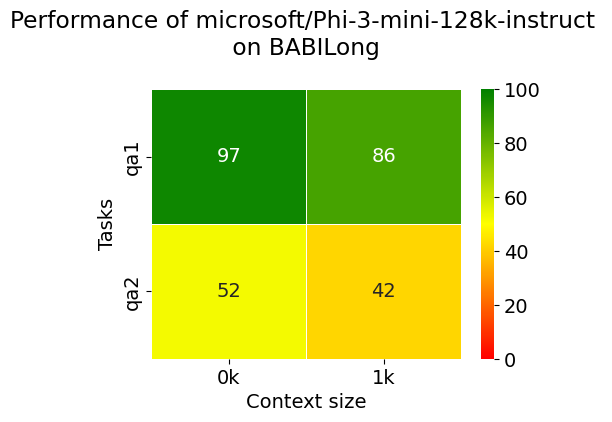

In [17]:
results_folder = './babilong_evals'
model_name = 'microsoft/Phi-3-mini-128k-instruct'
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes_chat_template_yes'

tasks = ['qa1', 'qa2']#, 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k']#, '2k', '4k', '8k', '16k', '32k']
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue

        df = pd.read_csv(fname)

        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output'],
                                                             row['question'], TASK_LABELS[task]
                                                             ), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

We have more examples with evaluation of various models in ./notebooks and ./scripts folders.

E.g. how to run models that are hosted on HuggingFace with default prompts `scripts/run_model_on_babilong.py`.

```bash
RESULTS_FOLDER="./babilong_evals"
DATASET_NAME="booydar/babilong-1k-samples"
MODEL_NAME="mistralai/Mistral-7B-Instruct-v0.2"
TASKS=("qa1" "qa2" "qa3" "qa4" "qa5")
LENGTHS=("0k" "1k" "2k" "4k" "8k" "16k" "32k")
USE_CHAT_TEMPLATE=true
USE_INSTRUCTION=true
USE_EXAMPLES=true
USE_POST_PROMPT=true
API_URL=""

echo running $MODEL_NAME on "${TASKS[@]}" with "${LENGTHS[@]}"

python scripts/run_model_on_babilong.py \
    --results_folder "$RESULTS_FOLDER" \
    --dataset_name "$DATASET_NAME" \
    --model_name "$MODEL_NAME" \
    --tasks "${TASKS[@]}" \
    --lengths "${LENGTHS[@]}" \
    $( [ "$USE_CHAT_TEMPLATE" == true ] && echo "--use_chat_template" ) \
    $( [ "$USE_INSTRUCTION" == true ] && echo "--use_instruction" ) \
    $( [ "$USE_EXAMPLES" == true ] && echo "--use_examples" ) \
    $( [ "$USE_POST_PROMPT" == true ] && echo "--use_post_prompt" ) \
    --api_url "$API_URL"
```

It is also possible to evaluate models that are running through API (e.g., llamacpp):
```bash
RESULTS_FOLDER="./babilong_evals"
DATASET_NAME="booydar/babilong"
MODEL_NAME="CohereForAI/c4ai-command-r-v01"
TASKS=("qa1" "qa2" "qa3" "qa4" "qa5")
LENGTHS=("64k" "128k")
USE_CHAT_TEMPLATE=true
USE_INSTRUCTION=true
USE_EXAMPLES=true
USE_POST_PROMPT=true
API_URL="http://localhost:8081/completion"

echo running $MODEL_NAME on "${TASKS[@]}" with "${LENGTHS[@]}"

python scripts/run_model_on_babilong.py \
    --results_folder "$RESULTS_FOLDER" \
    --dataset_name "$DATASET_NAME" \
    --model_name "$MODEL_NAME" \
    --tasks "${TASKS[@]}" \
    --lengths "${LENGTHS[@]}" \
    $( [ "$USE_CHAT_TEMPLATE" == true ] && echo "--use_chat_template" ) \
    $( [ "$USE_INSTRUCTION" == true ] && echo "--use_instruction" ) \
    $( [ "$USE_EXAMPLES" == true ] && echo "--use_examples" ) \
    $( [ "$USE_POST_PROMPT" == true ] && echo "--use_post_prompt" ) \
    --api_url "$API_URL"
```